# XHEC: Session 6-2  

Explore topic extraction and sentiment analysis existing libraries 

## Import libraries 

In [1]:
#!git clone https://github.com/rwalk/gsdmm
#pip install transformers==2.4.1
#pip install flair

In [13]:
import os
import numpy as np
import pandas as pd
import pickle
import gensim
import gensim.corpora as corpor
import pyLDAvis.gensim
import pyLDAvis
from gsdmm.gsdmm import MovieGroupProcess
from gensim.models.coherencemodel import CoherenceModel
import operator
from tqdm import tqdm_notebook as tqdm
import flair
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [3]:
nltk.download('vader_lexicon')
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/akhilavangara/nltk_data...


2020-03-12 16:03:14,698 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/models-v0.4/classy-imdb-en-rnn-cuda%3A0/imdb-v0.4.pt not found in cache, downloading to /var/folders/kg/5pw0jyrx3w53m80k0db4z9wc0000gn/T/tmp048aq59k


100%|██████████| 1501979561/1501979561 [13:50<00:00, 1808576.52B/s]

2020-03-12 16:17:05,395 copying /var/folders/kg/5pw0jyrx3w53m80k0db4z9wc0000gn/T/tmp048aq59k to cache at /Users/akhilavangara/.flair/models/imdb-v0.4.pt


2020-03-12 16:17:11,946 removing temp file /var/folders/kg/5pw0jyrx3w53m80k0db4z9wc0000gn/T/tmp048aq59k
2020-03-12 16:17:12,465 loading file /Users/akhilavangara/.flair/models/imdb-v0.4.pt


## Load data 

In [2]:
document = pickle.load(open('comments_subsample.pkl', "rb" ))

In [7]:
def read_jl_file(file_name):
    values = []
    with open(file_name, 'rb') as f:
        line = '---'
        while len(line)>1:
            line = f.readline()
            values.append(line)
    values = values[:-1]
    values = [json.loads(i) for i in values]
    df = pd.DataFrame(values)
    return df

# Reading file
#df = read_jl_file('/Users/Thomas/Documents/Data Science X/Cours/Capgemini project/1 - Scrapping : SWOT/ReviewRestoSpider.jl')

document = read_jl_file('ReviewRestoSpider_10pages (1).jl')
document.Rating = document.Rating.apply(lambda x: x[0])
document.Rating = document.Rating.apply(lambda x: int(x[0]))

In [15]:
def preprocess_data(raw_text):
    """
    Input  : raw text to clean
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    
    # list for tokenized documents in loop
    document["clean_content"] = ""
    
    # clean and tokenize document string
    raw = raw_text.lower()
    tokens = tokenizer.tokenize(raw)
    
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]

    return stemmed_tokens

document['clean_content'] = document['partial content'].apply(preprocess_data)

In [16]:
document.head()

,partial content,name,title,Restaurant_name,Rating,clean_content
0,I have been using this restaurant for years. T...,tracey h,"Best authentic Food, Chefs are top quality",[ Karahi Junction ],5,"[use, restaur, year, chef, excel, alway, good,..."
1,"The most amazing breakfast, ingredients fresh ...",kazowen,Breakfast Bliss,[ Melucci's ],5,"[amaz, breakfast, ingredi, fresh, cook, perfec..."
2,We went with friends ( 2 couples). The food he...,elthamfams,Excellent Food,[ Melucci's ],5,"[went, friend, 2, coupl, food, excel, staff, g..."
3,So why not five stars? Everything was was very...,richardcC3581NV,"Friendly staff, good food, good portions",[ Awesome Thai ],4,"[five, star, everyth, pleasant, busi, popular,..."
4,"Great food, friendly staff, decent prices. I h...",leona939,Great food,[ Namaste Gurkha ],5,"[great, food, friendli, staff, decent, price, ..."


## Topic extraction 

### LDA with gensim 

In [17]:
#Dictionary
tokens = document.clean_content
dictionary = gensim.corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=0.05, no_above=0.9)
corpus = [dictionary.doc2bow(tok) for tok in tokens]

In [18]:
ldaModel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=42,
                                           alpha=0.1,
                                           eta=0.1,
                                           per_word_topics=True)

In [19]:
for i,topic in ldaModel.show_topics(formatted=True, num_topics=10, num_words=20):
    print(str(i)+": "+ topic+"\n")

0: 0.024*"time" + 0.019*"food" + 0.015*"good" + 0.014*"restaur" + 0.012*"servic" + 0.010*"visit" + 0.009*"tabl" + 0.009*"went" + 0.009*"order" + 0.008*"chicken" + 0.007*"meal" + 0.007*"lunch" + 0.007*"us" + 0.006*"first" + 0.006*"realli" + 0.006*"night" + 0.006*"back" + 0.006*"excel" + 0.005*"best" + 0.005*"go"

1: 0.028*"food" + 0.014*"great" + 0.013*"staff" + 0.013*"excel" + 0.013*"restaur" + 0.013*"friendli" + 0.012*"good" + 0.011*"visit" + 0.010*"servic" + 0.009*"menu" + 0.009*"realli" + 0.008*"recommend" + 0.008*"alway" + 0.007*"us" + 0.007*"even" + 0.007*"would" + 0.007*"meal" + 0.007*"love" + 0.006*"book" + 0.006*"friend"

2: 0.012*"us" + 0.009*"love" + 0.009*"good" + 0.009*"staff" + 0.008*"food" + 0.008*"servic" + 0.008*"well" + 0.008*"friendli" + 0.007*"tabl" + 0.007*"visit" + 0.006*"pub" + 0.006*"book" + 0.006*"excel" + 0.006*"made" + 0.006*"london" + 0.005*"restaur" + 0.005*"one" + 0.005*"look" + 0.005*"lunch" + 0.005*"welcom"

3: 0.037*"food" + 0.017*"amaz" + 0.016*"restaur

In [20]:
cm = CoherenceModel(model=ldaModel, corpus=corpus, texts=tokens ,coherence="c_v")
cm.get_coherence()

0.3769401482858222

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldaModel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.044550  0.020326       1        1  20.129698
9     -0.041079 -0.002467       2        1  19.059448
4     -0.031013 -0.005662       3        1  13.492298
1     -0.034391 -0.003182       4        1  10.276825
3     -0.034004  0.000045       5        1   9.152663
0     -0.004471 -0.007460       6        1   9.044754
7     -0.009305  0.007876       7        1   8.036951
6      0.091195  0.046124       8        1   4.400681
2      0.058521 -0.097177       9        1   3.262065
8      0.049095  0.041576      10        1   3.144617, topic_info=          Term         Freq        Total Category  logprob  loglift
198      place   718.000000   718.000000  Default  30.0000  30.0000
69        time   751.000000   751.000000  Default  29.0000  29.0000
8         food  2490.000000  2490.000000  Default  28.0000  28.0000
21        amaz   461.000000   461.000000  Default  27.0000  27.0000
207     servic  1316.000000  1316.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
69        time    13.090741   751.907043  Topic10  -5.3676  -0.5912
1    atmospher    11.099573   405.369324  Topic10  -5.5326  -0.1384
148         go    11.266904   485.848053  Topic10  -5.5176  -0.3045
55        went    10.653172   329.463806  Topic10  -5.5736   0.0279
115       meal    10.771746   515.405518  Topic10  -5.5625  -0.4085

[800 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2679      2  0.712618          0
2679      5  0.142524          0
880       1  0.077434         10
880       2  0.121682         10
880       3  0.398232         10
...     ...       ...        ...
695       8  0.029768  yesterday
695      10  0.208378  yesterday
2062      8  0.531632       york
2062     10  0.354422       york
3248      8  0.666163        yuk

[2090 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 10, 5, 2, 4, 1, 8, 7, 3, 9])

In [22]:
#with open(f'model/lda_model.pkl', 'wb') as f:
#    pickle.dump(ldaModel, f)
#    f.close()

### GSDMM 

In [23]:
document['nb_token'] = list(map(len, document['clean_content']))
docs = document.clean_content.to_list()
vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)

In [24]:
nb_topic = 10
alpha = 0.1
beta = 0.1

mgpModel = MovieGroupProcess(K=nb_topic, alpha=alpha, beta=beta, n_iters=20)
mgpModelFit = mgpModel.fit(tokens, n_terms)

# Save model
#with open(f'model/gsdmm_model.pkl', 'wb') as f:
#    pickle.dump(mgpModel, f)
#    f.close()

In stage 0: transferred 2957 clusters with 10 clusters populated
In stage 1: transferred 1853 clusters with 10 clusters populated
In stage 2: transferred 1279 clusters with 10 clusters populated
In stage 3: transferred 1017 clusters with 10 clusters populated
In stage 4: transferred 925 clusters with 10 clusters populated
In stage 5: transferred 842 clusters with 10 clusters populated
In stage 6: transferred 742 clusters with 10 clusters populated
In stage 7: transferred 749 clusters with 10 clusters populated
In stage 8: transferred 664 clusters with 10 clusters populated
In stage 9: transferred 590 clusters with 10 clusters populated
In stage 10: transferred 613 clusters with 10 clusters populated
In stage 11: transferred 583 clusters with 9 clusters populated
In stage 12: transferred 546 clusters with 9 clusters populated
In stage 13: transferred 523 clusters with 9 clusters populated
In stage 14: transferred 547 clusters with 10 clusters populated
In stage 15: transferred 531 clust

In [26]:
def topWordsPerTopic(clusterDistrib, topIndex, nbWord):
    for index in topIndex:
        clusterWord = clusterDistrib[index]
        sortedCluster = sorted(clusterWord.items(), key=operator.itemgetter(1), reverse=True)
        clusterTopWords = sortedCluster[:nbWord]
        print(f"Cluster {index} : {clusterTopWords}")
        print('*'*20)

In [27]:
docCount = np.array(mgpModel.cluster_doc_count)
print('Number of documents per topic :', docCount)
print('*'*20)
# Topics sorted by the number of document they are allocated to
topIndex = docCount.argsort()[::-1]
print('Most important clusters (by number of docs inside):', topIndex)
print('*'*20)
# Show the top 30 words in term frequency for each cluster 
topWordsPerTopic(mgpModel.cluster_word_distribution, topIndex, 30)

Number of documents per topic : [   0   83  718    3 1361   88  160  599   28  613]
********************
Most important clusters (by number of docs inside): [4 2 9 7 6 5 1 8 3 0]
********************
Cluster 4 : [('food', 1032), ('great', 641), ('servic', 586), ('staff', 532), ('love', 430), ('restaur', 406), ('good', 375), ('friendli', 366), ('recommend', 317), ('visit', 297), ('time', 294), ('excel', 269), ('us', 234), ('even', 230), ('amaz', 226), ('atmospher', 226), ('realli', 221), ('would', 214), ('definit', 213), ('place', 210), ('back', 203), ('meal', 202), ('friend', 197), ('thank', 178), ('delici', 176), ('well', 168), ('go', 159), ('famili', 154), ('nice', 152), ('alway', 151)]
********************
Cluster 2 : [('food', 540), ('restaur', 325), ('servic', 247), ('place', 212), ('great', 197), ('good', 193), ('love', 173), ('recommend', 172), ('staff', 165), ('friendli', 162), ('time', 151), ('best', 143), ('visit', 141), ('amaz', 135), ('alway', 135), ('delici', 126), ('tri',

### pyLDAvis with gsdmm

In [28]:
#Topic-term matrix shape (n_topic, n_term)
def createTopicTermMatrix(vocab, mgp):
    zero = np.zeros((len(mgp.cluster_word_distribution), len(vocab)))
    df = pd.DataFrame(data=zero, columns=list(vocab))
    for i, cluster_word_distrib in tqdm(enumerate(mgp.cluster_word_distribution)):
        for key, val in cluster_word_distrib.items():
            df.loc[i, key] = val
    return df

In [29]:
TopicTermMatrix = createTopicTermMatrix(vocab, mgpModel)

//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [30]:
#Matrix of document-topic probabilities shape (n_doc, n_topics)
def createDocumentTopicProbaMatrix(mgp, doc_list):
    score_per_doc = []
    for doc in tqdm(doc_list):
        score_per_doc.append(mgp.score(doc))
    df = pd.DataFrame(data=score_per_doc, columns=[i for i in range(nb_topic)])
    return df

In [31]:
probaDocumentTopicMatrix = createDocumentTopicProbaMatrix(mgpModel, docs)

//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [32]:
def deleteNonPorcessedDocument(probaDocumentTopicMatrix, document):
    check = probaDocumentTopicMatrix.sum(axis=1)
    toDelete = check[check==0]
    idxToDelete = toDelete.index 
    probaDocumentTopicMatrix = probaDocumentTopicMatrix.drop(idxToDelete)
    
    idx = list(map(lambda x: document.index[x], idxToDelete))
    document = document.drop(idx)
    return probaDocumentTopicMatrix, document

In [33]:
probaDocumentTopicMatrixClean, documentClean = deleteNonPorcessedDocument(probaDocumentTopicMatrix, document)

In [34]:
#doc length shape (n_doc)
docLength = documentClean.nb_token
print(len(documentClean))

3631


In [35]:
#doc length shape (n_term)
vocabList = list(vocab) 

In [36]:
#Term frequency shape (n_term)
def TermFrequency(vocab_list, doc_list):
    res = []
    for word in tqdm(vocab_list):
        word_per_doc = sum(list(map(lambda x: x.count(word), doc_list)))
        res.append(word_per_doc)
    return res

In [37]:
termFrequencyList = TermFrequency(vocabList, docs)

//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
%%time
vis = pyLDAvis.prepare(TopicTermMatrix, probaDocumentTopicMatrixClean, docLength, vocabList, termFrequencyList, sort_topics=False)
pyLDAvis.display(vis)

## Sentiment analysis 

In [44]:
i_comment = 0

sentence = document['partial content'][i_comment]

In [45]:
sentence

'I have been using this restaurant for years. The chefs are excellent, there are always good portions and the food is always fresh, you can see them cooking behind the glass, the atmosphere is always friendly with mixed types of diners, children are always welcomed too.'

### VADER Sentiment analysis 

In [46]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(sentence)

{'neg': 0.0, 'neu': 0.734, 'pos': 0.266, 'compound': 0.926}

In [47]:
sns.set(rc={'figure.figsize':(30,1)})

def visualise_sentiments(data):
    sns.heatmap(pd.DataFrame(data).set_index("Sentence").T,center=0, annot=True, cmap = "PiYG")

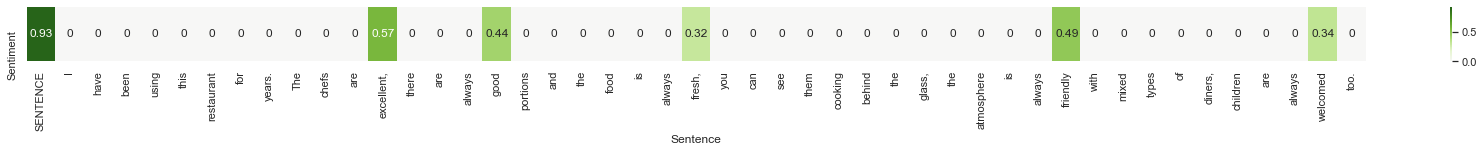

In [48]:
visualise_sentiments({
    "Sentence":["SENTENCE"] + sentence.split(),
    "Sentiment":[sid.polarity_scores(sentence)["compound"]] + [sid.polarity_scores(word)["compound"] for word in sentence.split()]
})

### Flair Sentiment analysis 

In [49]:
s = flair.data.Sentence(sentence)
flair_sentiment.predict(s)
total_sentiment = s.labels
total_sentiment

[POSITIVE (0.9324111938476562)]

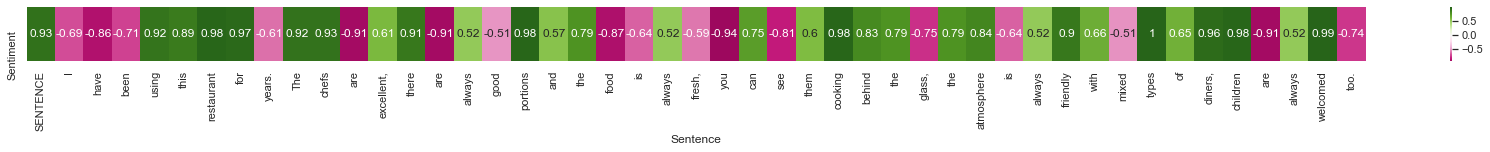

In [50]:
tokens = [token.text for token in s.tokens]
ss = [flair.data.Sentence(s) for s in tokens]
[flair_sentiment.predict(s) for s in ss]
sentiments = [s.labels[0].score * (-1,1)[str(s.labels[0]).split()[0].startswith("POS")] for s in ss]

visualise_sentiments({
      "Sentence":["SENTENCE"] + tokens,
      "Sentiment":[total_sentiment[0].score *(-1,1)[str(total_sentiment[0]).split()[0].startswith("POS")]] + sentiments,
})

### Rating vs Sentiment score 

#### Vader

In [53]:
document['vader_score'] = document['partial content'].map(lambda x: sid.polarity_scores(x)['compound'])

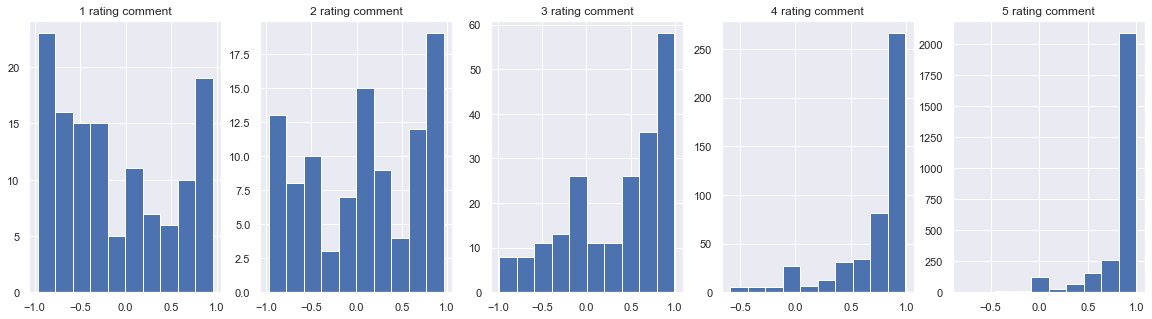

In [55]:
f = plt.figure(figsize=(20, 5))
for i in range(5):
    rating_doc = document[document['Rating']==i+1]
    plt.subplot(1, 5, i+1)
    plt.title(f'{i+1} rating comment')
    rating_doc.vader_score.hist()
plt.show()